# Group Project 1 - IE6600

## Air traffic analysis of San Francisco International Airport Report

## Group - 2
### Team members:

- 1) Venkata Sai Teja Dhulipudi
- 2) Nandury Kousik
- 3) Vashani Neil  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, shapiro, chi2_contingency, ttest_ind, f_oneway
import warnings
warnings.filterwarnings('ignore')

# 1) Data Loding and Inspection:

In [ ]:
# Load the dataset
df_airline = pd.read_csv('Air_Traffic_Passenger_Statistics.csv')

print(f"Dataset shape: {df_airline.shape}")
print("\n")
print(df_airline.head(5))

Dataset shape: (37852, 15)


   Activity Period Activity Period Start Date  \
0           199907                 1999/07/01   
1           199907                 1999/07/01   
2           199907                 1999/07/01   
3           199907                 1999/07/01   
4           199907                 1999/07/01   

                         Operating Airline Operating Airline IATA Code  \
0                             ATA Airlines                          TZ   
1                             ATA Airlines                          TZ   
2                             ATA Airlines                          TZ   
3  Aeroflot Russian International Airlines                         NaN   
4  Aeroflot Russian International Airlines                         NaN   

                         Published Airline Published Airline IATA Code  \
0                             ATA Airlines                          TZ   
1                             ATA Airlines                          TZ   
2        

In [ ]:
print("Dataset info:")
print(df_airline.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37852 entries, 0 to 37851
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Activity Period              37852 non-null  int64 
 1   Activity Period Start Date   37852 non-null  object
 2   Operating Airline            37852 non-null  object
 3   Operating Airline IATA Code  37536 non-null  object
 4   Published Airline            37852 non-null  object
 5   Published Airline IATA Code  37536 non-null  object
 6   GEO Summary                  37852 non-null  object
 7   GEO Region                   37852 non-null  object
 8   Activity Type Code           37852 non-null  object
 9   Price Category Code          37852 non-null  object
 10  Terminal                     37852 non-null  object
 11  Boarding Area                37852 non-null  object
 12  Passenger Count              37852 non-null  int64 
 13  data_as_of       

In [ ]:


print("Basic statistics:")
print(df_airline.describe())

Basic statistics:
       Activity Period  Passenger Count
count     37852.000000     37852.000000
mean     201261.456700     27820.665196
std         752.444011     62044.188248
min      199907.000000         0.000000
25%      200608.750000      4363.000000
50%      201306.000000      8600.000000
75%      201905.000000     19711.250000
max      202503.000000    856501.000000


## Insights:

- 1) The dataset consists of 37852 rows and 15 columns.
- 2) The datset containg datatypes such as objects and integers
- 3) The some of the data needs formatting like the date.
- 4) The average passenger count for the dataset (1999-2025) is about 27820, while the SD is 62044.

# 2) Data Cleaning and Preparation

In [ ]:

missing_values = df_airline.isnull().sum()
print(missing_values[missing_values > 0])

Operating Airline IATA Code    316
Published Airline IATA Code    316
dtype: int64


In [ ]:
# Convert Activity Period to proper datetime

df_airline['Year'] = df_airline['Activity Period'] // 100
df_airline['Month'] = df_airline['Activity Period'] % 100
df_airline['Date'] = pd.to_datetime(df_airline[['Year', 'Month']].assign(day=1))

In [ ]:
# Creating new derived features
df_airline['Has_IATA'] = df_airline['Operating Airline IATA Code'].notna()
df_airline['Passengers_per_Day'] = df_airline['Passenger Count'] / 30
df_airline['Pre_911'] = df_airline['Year'] < 2001
df_airline['Post_COVID'] = df_airline['Year'] >= 2020
df_airline['COVID_Period'] = (df_airline['Year'] >= 2020) & (df_airline['Year'] <= 2022)

In [ ]:
# Fill missing  value with Unknown

df_airline['Operating Airline IATA Code'] = df_airline['Operating Airline IATA Code'].fillna('Unknown')
df_airline['Published Airline IATA Code'] = df_airline['Published Airline IATA Code'].fillna('Unknown')

In [ ]:
# Cleaning up terminal Column
df_airline['Terminal_Clean'] = df_airline['Terminal'].replace({'Terminal 1': 'T1', 'Terminal 2': 'T2','Terminal 3': 'T3', 'International': 'INTL'})

## Insights:
- 1) There are a 316 missing values in the Airline code columns.
- 2) Filled the missing values with unkonown as this column is not useful for our analysis, but sill important not to remove this colunm.
- 3) converted the Activit period column from integer to datetime datatype.
- 4) Derived new columns from to have more granular data and to categorise them pased on global events like the 9-11 attack and pre covid and post covid, to understand the evvects of such events on Flight passengers.
- 5) cleaned the termunal colunm for easier interpretation.

# 3) Exploratory data analysis:

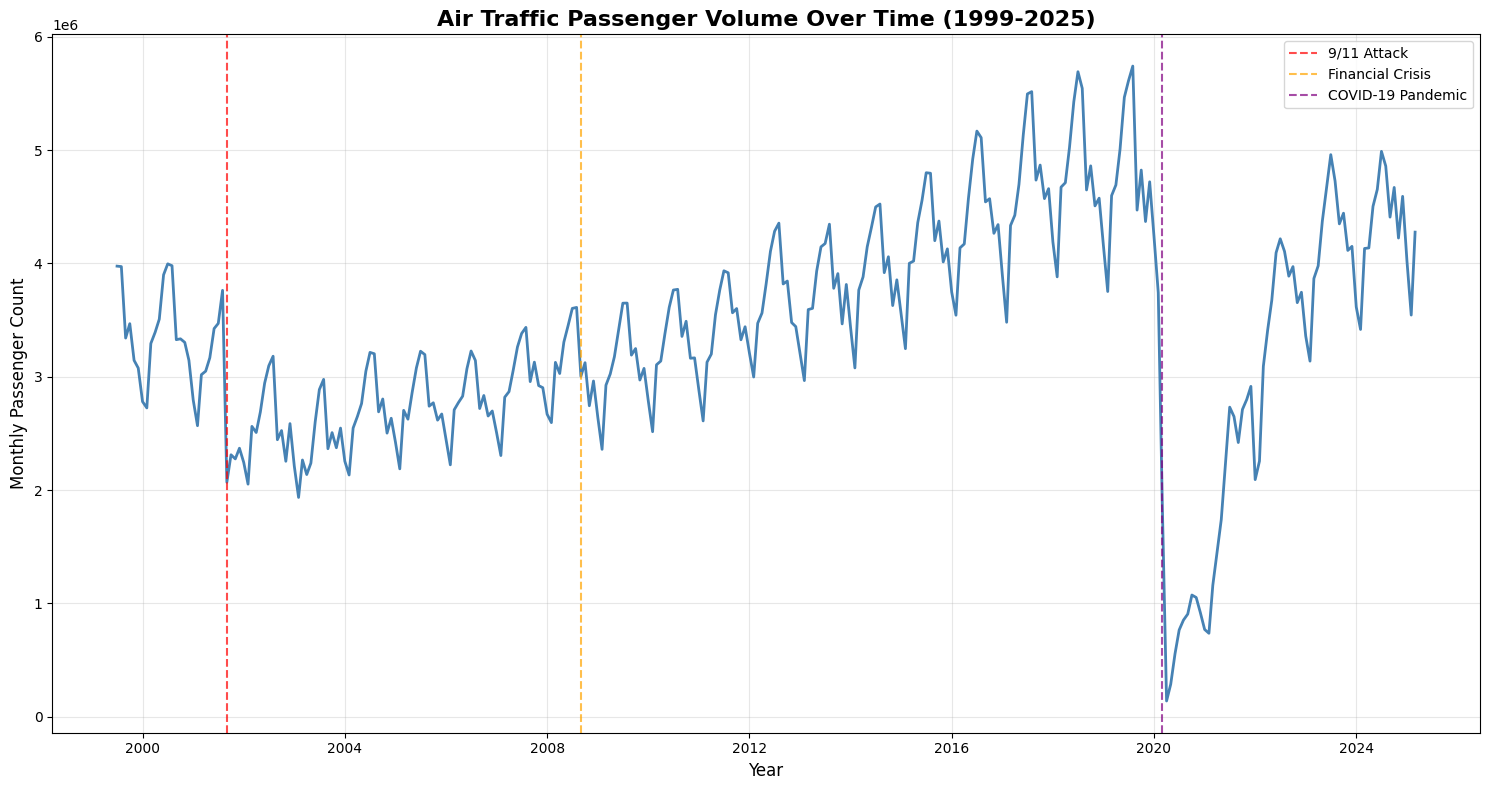

In [ ]:

# Monthly passenger trends
monthly_data = df_airline.groupby('Date')['Passenger Count'].sum().reset_index()

plt.figure(figsize=(15, 8))
plt.plot(monthly_data['Date'], monthly_data['Passenger Count'], linewidth=2, color='steelblue')
plt.title('Air Traffic Passenger Volume Over Time (1999-2025)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Monthly Passenger Count', fontsize=12)
plt.grid(True, alpha=0.3)

# Adding lines tp demote major events
plt.axvline(pd.to_datetime('2001-09-01'), color='red', linestyle='--', alpha=0.7, label='9/11 Attack')
plt.axvline(pd.to_datetime('2008-09-01'), color='orange', linestyle='--', alpha=0.7, label='Financial Crisis')
plt.axvline(pd.to_datetime('2020-03-01'), color='purple', linestyle='--', alpha=0.7, label='COVID-19 Pandemic')

plt.legend()
plt.tight_layout()
plt.show()

# Insights:

- 1) The Monthly passenger count over the years shows the trend which fluctuates over time.
- 2) There are noticable dips in the count during the time of major incidents which are annotated in the plot.
- 3) the Maxinimum dip is found in the year 2020 due to the pandemic quarantine situation.

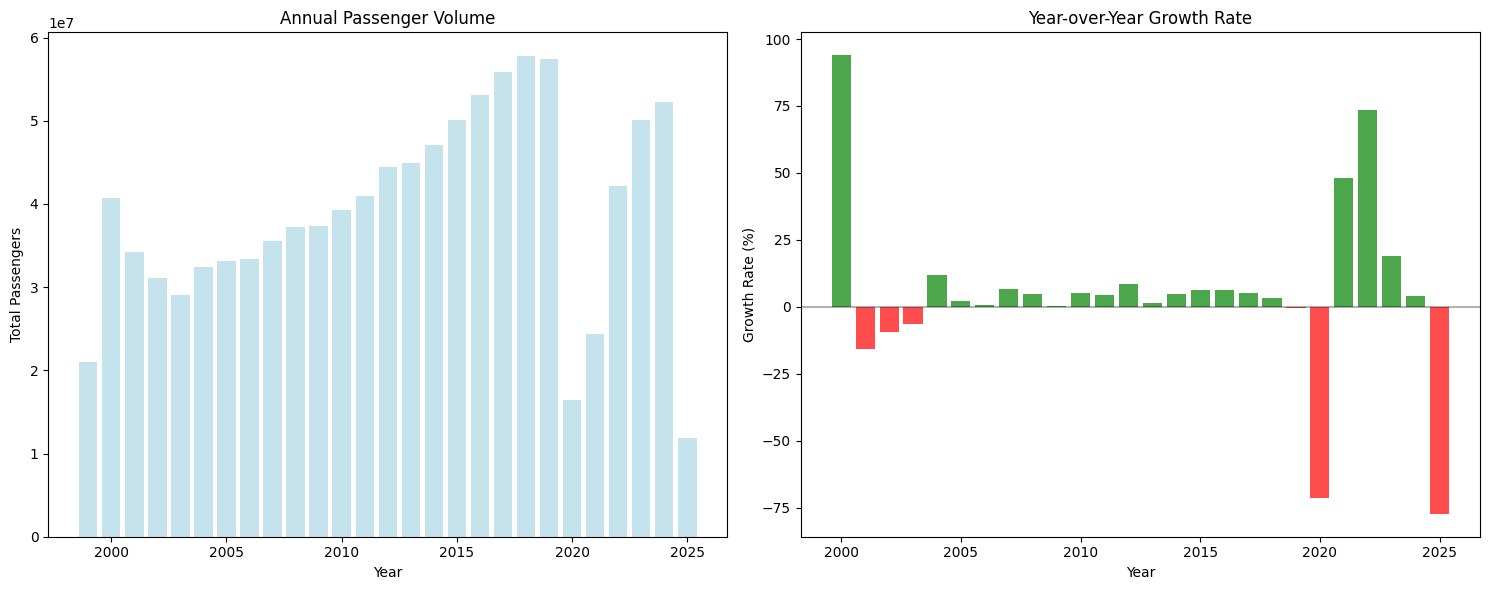

In [ ]:
yearly_data = df_airline.groupby('Year')['Passenger Count'].sum().reset_index()

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(yearly_data['Year'], yearly_data['Passenger Count'], color='lightblue', alpha=0.7)
plt.title('Annual Passenger Volume')
plt.xlabel('Year')
plt.ylabel('Total Passengers')


plt.subplot(1, 2, 2)
yearly_data['Growth_Rate'] = yearly_data['Passenger Count'].pct_change() * 100
plt.bar(yearly_data['Year'][1:], yearly_data['Growth_Rate'][1:],
        color=['red' if x < 0 else 'green' for x in yearly_data['Growth_Rate'][1:]], alpha=0.7)
plt.title('Year-over-Year Growth Rate')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

# Insights:

- 1) Annual passenger plot shows the yearly trend of the passenger count with 2018 being the year with the highest travelers count while 2020 being the lowest.
- 2) Year over year growth shows some importand differentiation bewtween years with positive growth and negitive growth. We will not consider the year 2025 as it has incomplete data.
- 3) The secong plot again emphasises on the role of global terrorism and diseases.

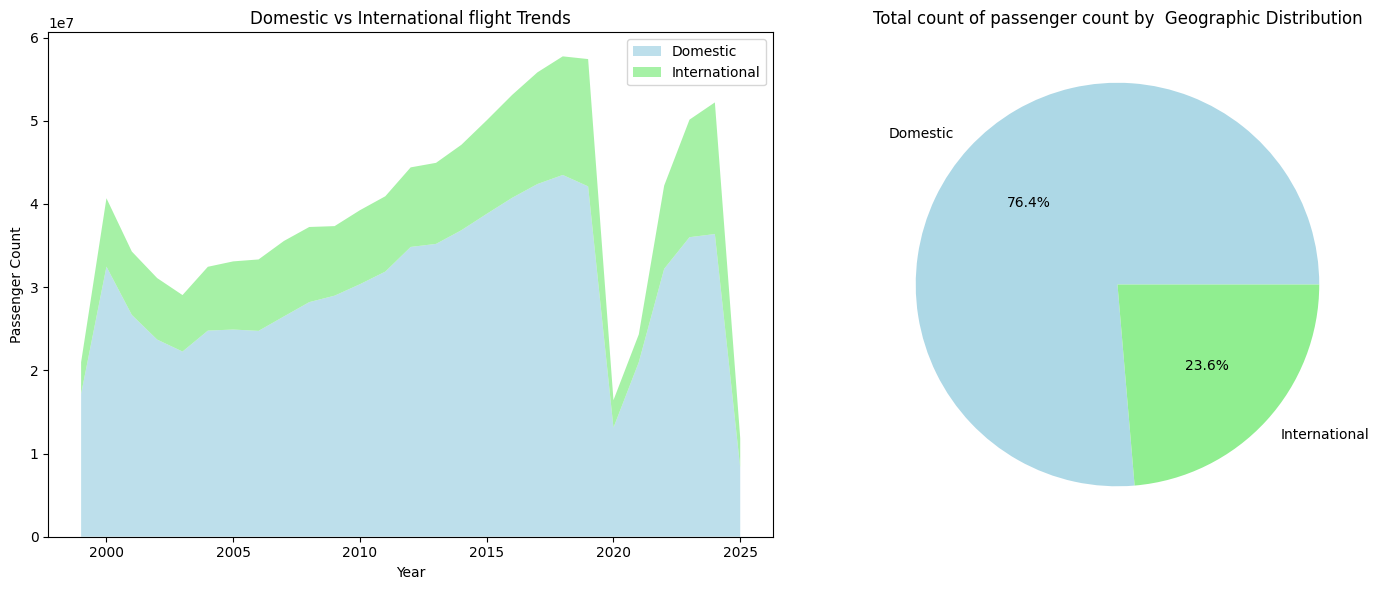

In [ ]:

geo_data = df_airline.groupby(['GEO Summary', 'Year'])['Passenger Count'].sum().reset_index()
geo_pivot = geo_data.pivot(index='Year', columns='GEO Summary', values='Passenger Count')

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.stackplot(geo_pivot.index, geo_pivot['Domestic'], geo_pivot['International'],
              labels=['Domestic', 'International'], alpha=0.8, colors=['lightblue', 'lightgreen'])
plt.title('Domestic vs International flight Trends', )
plt.xlabel('Year')
plt.ylabel('Passenger Count')
plt.legend()


plt.subplot(1, 2, 2)
geo_summary = df_airline.groupby('GEO Summary')['Passenger Count'].sum()
plt.pie(geo_summary.values, labels=geo_summary.index, autopct='%1.1f%%',
        colors=['lightblue', 'lightgreen'])
plt.title('Total count of passenger count by  Geographic Distribution')

plt.tight_layout()
plt.show()

# Insights:

- 1) The first domestic vs international plot shows that the total number of International flights are more that the number of flights that are domestic.
- 2) the second pie chart tells us that even though there are more international flights, passengers tavelling in the domestic are more.

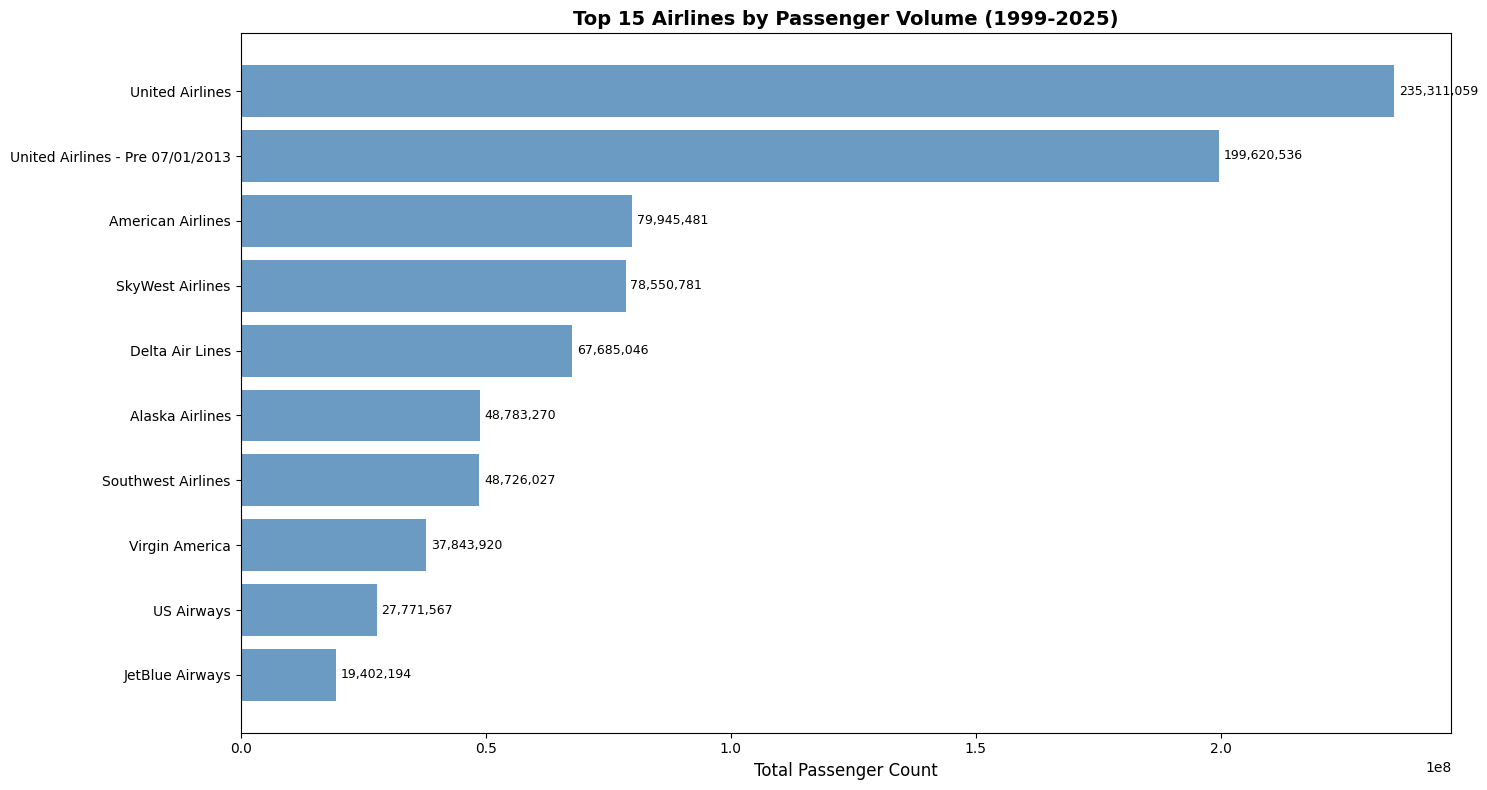

In [ ]:

# Top 10 airlines by passenger volume
top_airlines = df_airline.groupby('Operating Airline')['Passenger Count'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(15, 8))
plt.barh(range(len(top_airlines)), top_airlines.values, color='steelblue', alpha=0.8)
plt.yticks(range(len(top_airlines)), top_airlines.index, fontsize=10)
plt.xlabel('Total Passenger Count', fontsize=12)
plt.title('Top 15 Airlines by Passenger Volume (1999-2025)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for i, v in enumerate(top_airlines.values):
    plt.text(v + 1000000, i, f'{v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()



# Insights:

- The top 5 airlines by the number of passesgers travelled are:

1.   United Airlines
2.   American airlines
3.   Skywest airlines
4.   Delta airlines
5.   Alaska airlines











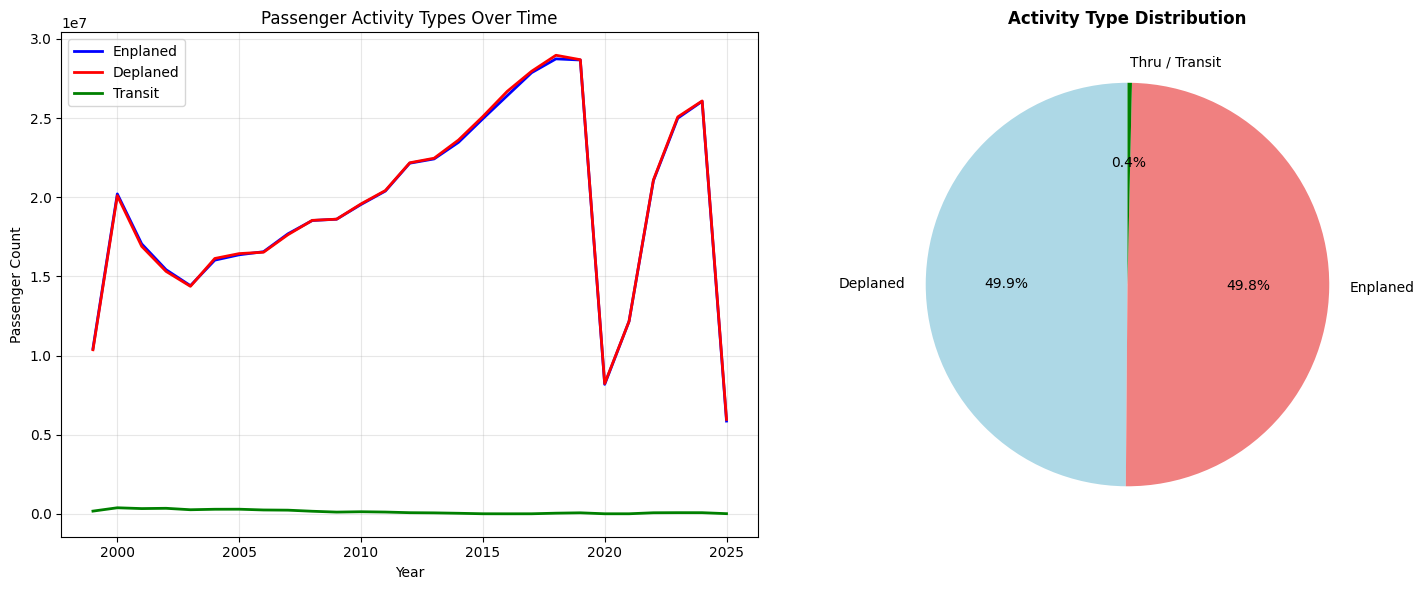

In [ ]:
activity_data = df_airline.groupby(['Activity Type Code', 'Year'])['Passenger Count'].sum().reset_index()
activity_pivot = activity_data.pivot(index='Year', columns='Activity Type Code', values='Passenger Count')

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(activity_pivot.index, activity_pivot['Enplaned'], label='Enplaned', linewidth=2, color='blue')
plt.plot(activity_pivot.index, activity_pivot['Deplaned'], label='Deplaned', linewidth=2, color='red')
plt.plot(activity_pivot.index, activity_pivot['Thru / Transit'], label='Transit', linewidth=2, color='green')
plt.title('Passenger Activity Types Over Time')
plt.xlabel('Year')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
activity_summary = df_airline.groupby('Activity Type Code')['Passenger Count'].sum()
plt.pie(activity_summary.values, labels=activity_summary.index, autopct='%1.1f%%',
        colors=['lightblue', 'lightcoral', 'green'], startangle=90)
plt.title('Activity Type Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

## Insights:

- 1) Both the pie chart and the line chart show that the number of passengers that are enplained(departure) and deplained(arrived) are almost the same, with a few of them in transit.

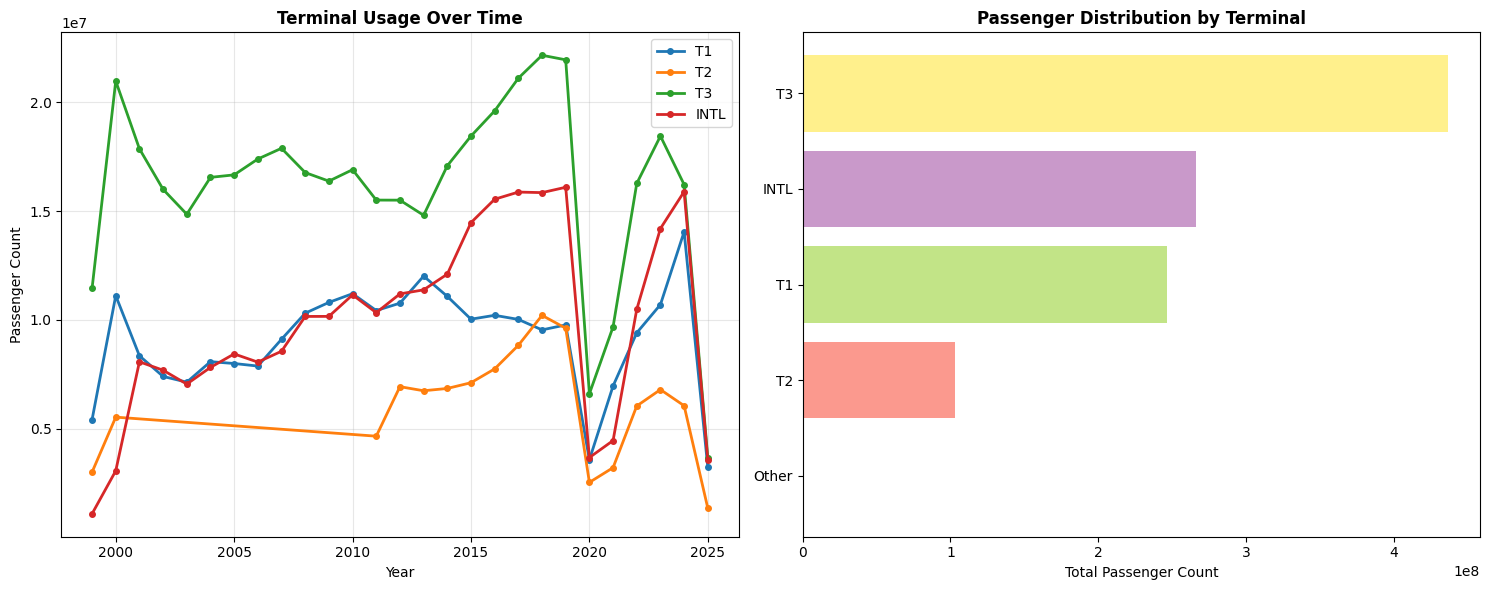

In [ ]:

terminal_data = df_airline.groupby(['Terminal_Clean', 'Year'])['Passenger Count'].sum().reset_index()

plt.figure(figsize=(15, 6))

# Terminal usage over time
plt.subplot(1, 2, 1)
for terminal in df_airline['Terminal_Clean'].unique():
    if terminal != 'Other':
        terminal_yearly = terminal_data[terminal_data['Terminal_Clean'] == terminal]
        plt.plot(terminal_yearly['Year'], terminal_yearly['Passenger Count'],
                label=terminal, linewidth=2, marker='o', markersize=4)

plt.title('Terminal Usage Over Time', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, alpha=0.3)

# Terminal distribution
plt.subplot(1, 2, 2)
terminal_summary = df_airline.groupby('Terminal_Clean')['Passenger Count'].sum().sort_values(ascending=True)
colors = plt.cm.Set3(np.linspace(0, 1, len(terminal_summary)))
plt.barh(range(len(terminal_summary)), terminal_summary.values, color=colors, alpha=0.8)
plt.yticks(range(len(terminal_summary)), terminal_summary.index)
plt.xlabel('Total Passenger Count')
plt.title('Passenger Distribution by Terminal', fontweight='bold')

plt.tight_layout()
plt.show()

## Insights:

- 1) Terminal useage line and bar plots show Terminl 3 being mostly use which is true as it mainly used for domestic flights.

# Statistic Analysis:

In [ ]:

passenger_stats = df_airline['Passenger Count'].describe()
print("Passenger Count Statistics:")
print(passenger_stats)

# Additional statistics
print(f"\nSkewness: {stats.skew(df_airline['Passenger Count']):.3f}")
print(f"Kurtosis: {stats.kurtosis(df_airline['Passenger Count']):.3f}")
print(f"Coefficient of Variation: {(df_airline['Passenger Count'].std() / df_airline['Passenger Count'].mean()):.3f}")

Passenger Count Statistics:
count     37852.000000
mean      27820.665196
std       62044.188248
min           0.000000
25%        4363.000000
50%        8600.000000
75%       19711.250000
max      856501.000000
Name: Passenger Count, dtype: float64

Skewness: 5.120
Kurtosis: 33.536
Coefficient of Variation: 2.230


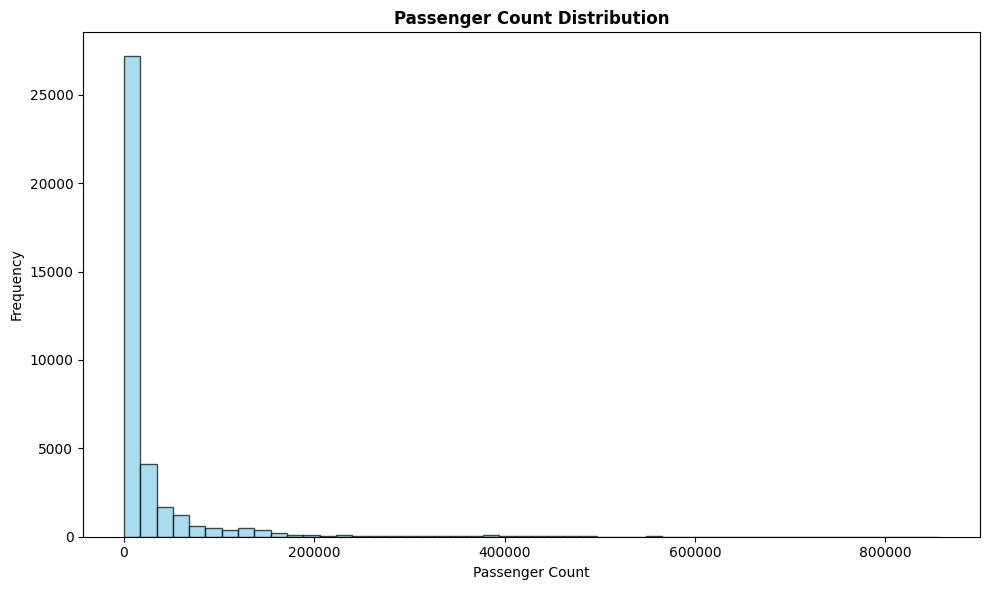

In [ ]:
# Distribution analysis
plt.figure(figsize=(10, 6))


plt.hist(df_airline['Passenger Count'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.title('Passenger Count Distribution', fontweight='bold')



plt.tight_layout()
plt.show()

In [ ]:
pre_911 = df_airline[df_airline['Pre_911'] == True]['Passenger Count']
post_911 = df_airline[df_airline['Pre_911'] == False]['Passenger Count']

t_stat, p_value = ttest_ind(pre_911, post_911)
print(f"Pre/Post 9/11 t-test:")
print(f"Pre-9/11 mean: {pre_911.mean():.0f}")
print(f"Post-9/11 mean: {post_911.mean():.0f}")


Pre/Post 9/11 t-test:
Pre-9/11 mean: 28149
Post-9/11 mean: 27801


In [ ]:
pre_covid = df_airline[df_airline['Year'] < 2020]['Passenger Count']
covid_period = df_airline[df_airline['COVID_Period'] == True]['Passenger Count']

t_stat_covid, p_value_covid = ttest_ind(pre_covid, covid_period)
print(f"\nPre-COVID vs COVID period t-test:")
print(f"Pre-COVID mean: {pre_covid.mean():.0f}")
print(f"COVID period mean: {covid_period.mean():.0f}")



Pre-COVID vs COVID period t-test:
Pre-COVID mean: 28964
COVID period mean: 20344
t-statistic: 8.227, p-value: 1.985e-16


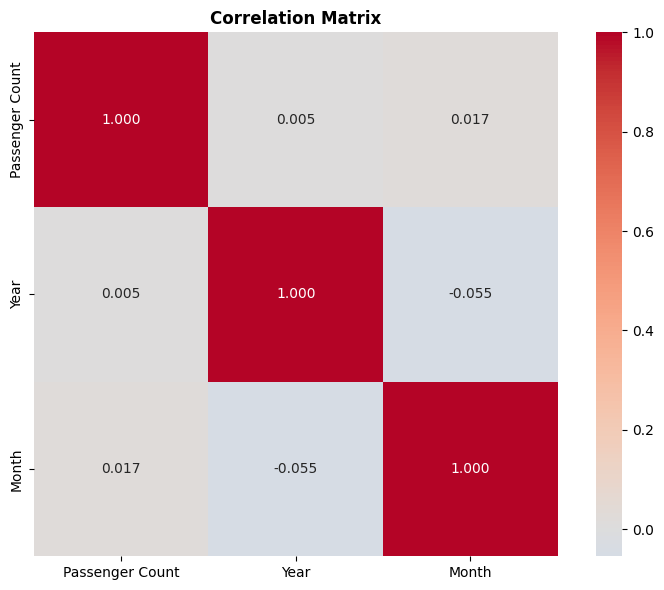

In [ ]:
corr_vars = ['Passenger Count', 'Year', 'Month']
correlation_matrix = df_airline[corr_vars].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Correlation Matrix', fontweight='bold')
plt.tight_layout()
plt.show()

# Advance analysis

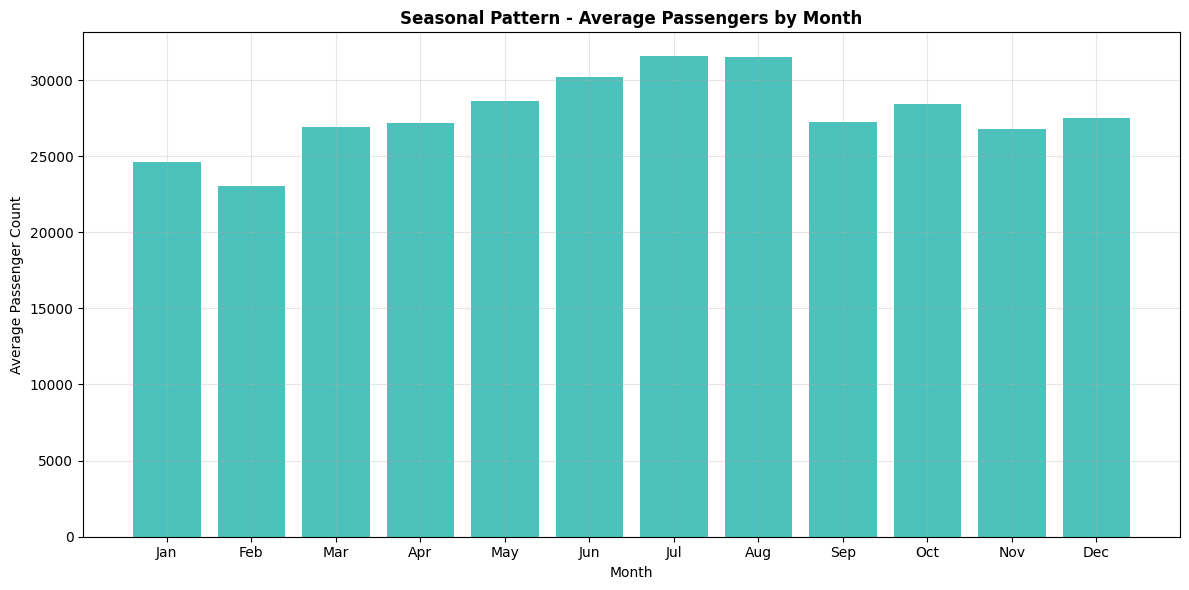

In [ ]:

monthly_pattern = df_airline.groupby('Month')['Passenger Count'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(monthly_pattern['Month'], monthly_pattern['Passenger Count'],
        color='lightseagreen', alpha=0.8)
plt.xlabel('Month')
plt.ylabel('Average Passenger Count')
plt.title('Seasonal Pattern - Average Passengers by Month', fontweight='bold')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Insights:

- 1) the seasonal pattern graph shows the trend where most of the passengers traveled during the months of June July, August, due to the hot favorable conditions while the passenger cone decreased during the cold years of November December, June and February .

- 2) this pattern shows that there is a seasonal trend for the flights.

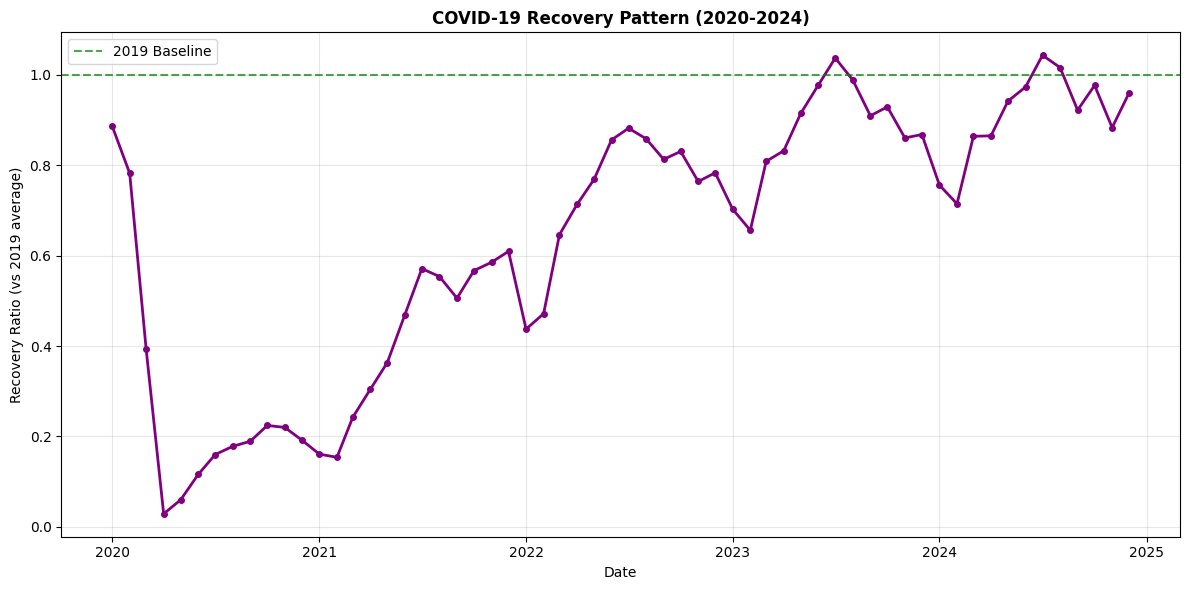

In [ ]:

recovery_analysis = df_airline.groupby(['Year', 'Month'])['Passenger Count'].sum().reset_index()
recovery_analysis['Date'] = pd.to_datetime(recovery_analysis[['Year', 'Month']].assign(day=1))

baseline_2019 = recovery_analysis[recovery_analysis['Year'] == 2019]['Passenger Count'].mean()
recovery_data = recovery_analysis[recovery_analysis['Year'].isin([2020, 2021, 2022, 2023, 2024])]
recovery_data['Recovery_Ratio'] = recovery_data['Passenger Count'] / baseline_2019

plt.figure(figsize=(12, 6))
plt.plot(recovery_data['Date'], recovery_data['Recovery_Ratio'],
         linewidth=2, color='purple', marker='o', markersize=4)
plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.7, label='2019 Baseline')
plt.xlabel('Date')
plt.ylabel('Recovery Ratio (vs 2019 average)')
plt.title('COVID-19 Recovery Pattern (2020-2024)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Insights:

- 1) the Covid recovery graph shows all the years post 2020 and the graph shows a consistent increase in the passenger account from 2022 and it reaches the baseline average which was said by the year 2019 in the year 2024.

# Summary:

In [ ]:

total_passengers = df_airline['Passenger Count'].sum()
avg_monthly = df_airline.groupby('Date')['Passenger Count'].sum().mean()
peak_year = df_airline.groupby('Year')['Passenger Count'].sum().idxmax()
lowest_year = df_airline.groupby('Year')['Passenger Count'].sum().idxmin()

covid_impact = (df_airline[df_airline['Year'] == 2020]['Passenger Count'].sum() /
                df_airline[df_airline['Year'] == 2019]['Passenger Count'].sum() - 1) * 100

print("KEY FINDINGS:")
print(f"• Total passengers (1999-2025): {total_passengers:,}")
print(f"• Average monthly passengers: {avg_monthly:,.0f}")
print(f"• Peak year: {peak_year}")
print(f"• Lowest year: {lowest_year}")
print(f"• COVID-19 impact (2020 vs 2019): {covid_impact:.1f}%")
print(f"• International vs Domestic split: {df_airline.groupby('GEO Summary')['Passenger Count'].sum().apply(lambda x: f'{x/total_passengers*100:.1f}%').to_dict()}")
print(f"• Top airline: {top_airlines.index[0]} ({top_airlines.iloc[0]:,} passengers)")

print("\nSTATISTICAL SIGNIFICANCE:")
print(f"• Pre/Post 9/11 difference: {'Significant' if p_value < 0.05 else 'Not significant'} (p = {p_value:.3e})")
print(f"• COVID impact: {'Significant' if p_value_covid < 0.05 else 'Not significant'} (p = {p_value_covid:.3e})")

print("\nDATA QUALITY:")
print(f"• Missing IATA codes: {missing_values['Operating Airline IATA Code']} records ({missing_values['Operating Airline IATA Code']/len(df_airline)*100:.1f}%)")
print(f"• Date range completeness: {len(monthly_data)} months of data")
print(f"• Airlines covered: {df_airline['Operating Airline'].nunique()} unique carriers")


KEY FINDINGS:
• Total passengers (1999-2025): 1,053,067,819
• Average monthly passengers: 3,407,986
• Peak year: 2018
• Lowest year: 2025
• COVID-19 impact (2020 vs 2019): -71.4%
• International vs Domestic split: {'Domestic': '76.4%', 'International': '23.6%'}
• Top airline: United Airlines (235,311,059 passengers)

STATISTICAL SIGNIFICANCE:
• Pre/Post 9/11 difference: Not significant (p = 7.987e-01)
• COVID impact: Significant (p = 1.985e-16)

DATA QUALITY:
• Missing IATA codes: 316 records (0.8%)
• Date range completeness: 309 months of data
• Airlines covered: 138 unique carriers
